In [2]:
# 1 install

# Install required packages
!pip install -q langgraph langchain langchain-openai langchain-chroma
!pip install -q langchain-community chromadb pypdf python-dotenv


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: C:\Users\hp\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: C:\Users\hp\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: C:\Users\hp\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [2]:
# import

from langgraph.graph import START, END, StateGraph, MessagesState
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import ToolNode
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage
from langchain_core.tools import tool
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_chroma import Chroma
from langchain_community.document_loaders import PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from dotenv import load_dotenv
from IPython.display import Image, display
from typing import Literal
import os

print("✅ All imports successful")

✅ All imports successful


In [3]:
# Load API key
load_dotenv()
openai_api_key = os.getenv("OPENAI_API_KEY")

if not openai_api_key:
    raise ValueError("OPENAI_API_KEY not found! Please set it in your .env file.")

print("✅ API key loaded")

✅ API key loaded


In [4]:
# Initialize LLM
llm = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0.5,
    api_key=openai_api_key
)

print(f"✅ LLM initialized: {llm.model_name}")

✅ LLM initialized: gpt-4o-mini


In [8]:
# LOAD AND PROCESS DOCUMENT

# path to PDF file
file_path = "./Practical-Poultry-Raising.pdf."


# Load the PDF
loader = PyPDFLoader(file_path)
pages = []
    
# Load all pages from all PDFs in the folder
pages = loader.load()
    
print(f"✅ Loaded {len(pages)} pages from PDF")

✅ Loaded 173 pages from PDF


In [9]:
# SPLIT INTO CHUNKS

# Create text splitter (Module 2 knowledge!)
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,      # Characters per chunk
    chunk_overlap=100     # Overlap to preserve context
)

# Split documents
doc_splits = text_splitter.split_documents(pages)

print(f"✅ Created {len(doc_splits)} chunks")
print(f"\nSample chunk:")
print(f"{doc_splits[0].page_content[:200]}...")

✅ Created 423 chunks

Sample chunk:
PRACTICAL POULTRY RAISING
(MAY 2015 REVISED EDITION)
PEACE CORPS PUBLICATION NO.  M0011...


In [10]:
# CREATING VECTOR STORE


# Initialize embeddings (using OpenAI)
embeddings = OpenAIEmbeddings(
    model="text-embedding-3-small",
    api_key=openai_api_key
)

print("✅ Embeddings model initialized")

✅ Embeddings model initialized


In [11]:
# Create chroma vector store

# Create Chroma vector store
chroma_path = "./chroma_db_agentic_rag_task3"

# Create vector store from documents
vectorstore = Chroma(
    collection_name="agentic_rag_docs",
    persist_directory=chroma_path,
    embedding_function=embeddings
)

# Add documents
vectorstore.add_documents(documents=doc_splits)

print(f"✅ Vector store created with {len(doc_splits)} chunks")
print(f"   Persisted to: {chroma_path}")

✅ Vector store created with 423 chunks
   Persisted to: ./chroma_db_agentic_rag_task3


In [13]:
# Test the vector store
test_query = "Why Raise Poultry?"
test_results = vectorstore.similarity_search(test_query, k=2)

print(f"Query: {test_query}")
print(f"\nTop result:")
print(f"{test_results[0].page_content[:200]}...")
print(f"\n✅ Retrieval working!")

Query: Why Raise Poultry?

Top result:
many diseases and learned to take care of itself, these new breeds need the active care of the 
farmer to protect them from disease and predators if they are to survive and produce well.
Why Raise Pou...

✅ Retrieval working!


In [14]:
#  Create Retrieval Tool

@tool
def retrieve_documents(query: str) -> str:
    """
    Search for relevant documents in the knowledge base.
    
    Use this tool when you need information from the document collection
    to answer the user's question. Do NOT use this for:
    - General knowledge questions
    - Greetings or small talk
    - Simple calculations
    
    Args:
        query: The search query describing what information is needed
        
    Returns:
        Relevant document excerpts that can help answer the question
    """
    # Use MMR (Maximum Marginal Relevance) for diverse results
    retriever = vectorstore.as_retriever(
        search_type="mmr",
        search_kwargs={"k": 5, "fetch_k": 10}
    )
    
    # Retrieve documents
    results = retriever.invoke(query)
    
    if not results:
        return "No relevant documents found."
    
    # Format results
    formatted = "\n\n---\n\n".join(
        f"Document {i+1}:\n{doc.page_content}"
        for i, doc in enumerate(results)
    )
    
    return formatted

print("✅ Retrieval tool created")

✅ Retrieval tool created


In [15]:
# Test tool directly
test_result = retrieve_documents.invoke({"query": "What is DNA?"})
print(f"Tool result (first 300 chars):\n{test_result[:300]}...")

Tool result (first 300 chars):
Document 1:
determine the energy and protein and vitamin content of various feed ingredients. For 
example, note the differences in the percent of protein content of soybean meal in Appendix 
D.
Remember that many plants are likely to contain toxins. Do not use these substances in large 
quantities....


In [ ]:
#  BUILD THE AGENTIC RAG SYSTEM

In [16]:
system_prompt = SystemMessage(content="""You are an agricultural science practical instructor.

Using ONLY the information retrieved from the provided context documents,
explain practical poultry raising in a clear, step-by-step manner suitable
for secondary school students.

Your response should include:
1. Meaning of poultry raising
2. Types of poultry birds
3. Housing requirements
4. Feeding and watering practices
5. Hygiene and sanitation practices
6. Common poultry diseases and their prevention
7. Importance of poultry farming

Rules:
- Do not add information that is not found in the retrieved context.
- If the context does not contain enough information, say "Information not available in the provided documents."
- Use simple language and short paragraphs.
- Present steps in numbered or bullet form where appropriate.
""")

print("✅ System prompt configured")

✅ System prompt configured


In [ ]:
# DEFINE AGENT NODE

In [17]:
# Bind tool to LLM
tools = [retrieve_documents]
llm_with_tools = llm.bind_tools(tools)

def assistant(state: MessagesState) -> dict:
    """
    Assistant node - decides whether to retrieve or answer directly.
    """
    messages = [system_prompt] + state["messages"]
    response = llm_with_tools.invoke(messages)
    return {"messages": [response]}

def should_continue(state: MessagesState) -> Literal["tools", "__end__"]:
    """
    Decide whether to call tools or finish.
    """
    last_message = state["messages"][-1]
    
    if last_message.tool_calls:
        return "tools"
    return "__end__"

print("✅ Agent nodes defined")

✅ Agent nodes defined


In [ ]:
# BUILD THE GRAPH

In [18]:
# Build graph
builder = StateGraph(MessagesState)

# Add nodes
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    should_continue,
    {"tools": "tools", "__end__": END}
)
builder.add_edge("tools", "assistant")

# Add memory
memory = MemorySaver()
agent = builder.compile(checkpointer=memory)

print("✅ Agentic RAG system compiled")

✅ Agentic RAG system compiled


In [ ]:
# VISUALIZE

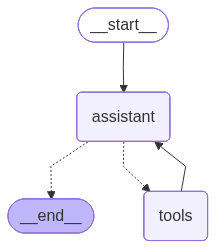

In [19]:
# Visualize the agentic RAG graph
try:
    display(Image(agent.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Could not display graph: {e}")
    print("Graph: START → assistant → [if tool_call] → tools → assistant → END")

In [ ]:
# TESTING THE AGENTIC RAG SYSTEM

In [20]:
def query_agent(user_input: str, thread_id: str = "none"):
    """
    Improved query function with clearer output.
    """
    # Generate a unique thread_id if none provided to ensure tests are independent
    if thread_id is None:
        thread_id = str(uuid.uuid4())
    
    print(f"\n{'='*70}")
    print(f"👤 User: {user_input}")
    print(f"{'='*70}\n")

    result = agent.invoke(
        {"messages": [HumanMessage(content=user_input)]},
        config={"configurable": {"thread_id": thread_id}}
    )

    # Check what happened
    used_retrieval = False
    final_answer = None

    for message in result["messages"]:
        if isinstance(message, AIMessage):
            if message.tool_calls:
                used_retrieval = True
                print(f"🔍 Agent: [Calling retrieval tool...]")
            if message.content and not message.tool_calls:
                final_answer = message.content

    # Always print final answer
    if final_answer:
        print(f"🤖 Agent: {final_answer}")
    else:
        print(f"⚠️ No response generated after retrieval!")

    # Summary
    print(f"\n📊 Decision: {'USED RETRIEVAL' if used_retrieval else 'ANSWERED DIRECTLY'}")
    print(f"{'='*70}\n")



In [ ]:
#  TESTING AND EVALUATION
# Test with 10 diverse queries:
#   - 5 that require retrieval
#   - 5 that don't require retrieval

In [ ]:
#  Query 1: Retrieval needed
 
query_agent("What is poultry")




👤 User: What is poultry

🔍 Agent: [Calling retrieval tool...]
🤖 Agent: 1. **Meaning of Poultry Raising**:  
   Poultry raising refers to the practice of keeping domestic fowl for their eggs, meat, or both. This includes birds like chickens, turkeys, ducks, geese, guinea fowl, pheasants, quail, and pigeons. Chickens are the most commonly raised poultry worldwide.

2. **Types of Poultry Birds**:  
   - Chickens
   - Turkeys
   - Ducks
   - Geese
   - Guinea fowl
   - Pheasants
   - Quail
   - Pigeons

3. **Housing Requirements**:  
   Information not available in the provided documents.

4. **Feeding and Watering Practices**:  
   Information not available in the provided documents.

5. **Hygiene and Sanitation Practices**:  
   Information not available in the provided documents.

6. **Common Poultry Diseases and Their Prevention**:  
   Information not available in the provided documents.

7. **Importance of Poultry Farming**:  
   Poultry farming provides important dietary protein, e

In [24]:
# Query 2: General Knowledge (No retrieval)
query_agent("What is your name?")


👤 User: What is your name?

🔍 Agent: [Calling retrieval tool...]
🤖 Agent: Information not available in the provided documents.

📊 Decision: USED RETRIEVAL



In [25]:
#  Query 3: Retrieval needed
 
query_agent("What are the items needed to raise poultry")


👤 User: What are the items needed to raise poultry

🔍 Agent: [Calling retrieval tool...]
🔍 Agent: [Calling retrieval tool...]
🤖 Agent: To raise poultry, you need to provide several essential items to ensure the birds are healthy and productive. Here are the key items needed:

1. **Shelter**: A safe and secure place for the poultry to live.

2. **Protection**: Measures to protect the birds from diseases, pests, and predators.

3. **Temperature and Humidity Controls**: Equipment or methods to maintain appropriate temperature and humidity levels.

4. **Sanitation Supplies**: Tools and materials to keep the living area clean.

5. **Light Control**: Systems to manage light exposure for the birds.

6. **Feeding Equipment**: 
   - Feeders that can hold the food at an appropriate height for the birds.
   - Space for feeding, which varies based on the type and age of the birds.

7. **Watering Equipment**: Adequate waterers to ensure the birds have access to fresh water.

8. **Stress Management

In [26]:
#  Query 4: Retrieval needed
 
query_agent("What Resources Needed to Expand Beyond the Farmyard Flock")


👤 User: What Resources Needed to Expand Beyond the Farmyard Flock

🔍 Agent: [Calling retrieval tool...]
🔍 Agent: [Calling retrieval tool...]
🔍 Agent: [Calling retrieval tool...]
🤖 Agent: To expand beyond a farmyard flock of poultry, several resources are essential. Here are the key resources needed:

1. **Management Systems**: 
   - Effective management practices are necessary to oversee the increased scale of poultry production.

2. **Technical Assistance**: 
   - Access to international technical assistance agencies can provide support and guidance in improving poultry practices.

3. **Market Network**: 
   - Developing a market network is crucial for selling the poultry products. This includes understanding local demand and establishing distribution channels.

4. **Balanced Feeds**: 
   - Availability of balanced feeds that meet the nutritional needs of improved poultry breeds is important for their growth and productivity.

5. **Farmer Interest**: 
   - Engaging local farmers who 

In [27]:
#  Query 5: Retrieval needed
 
query_agent("What are the overview of chicken")


👤 User: What are the overview of chicken

🔍 Agent: [Calling retrieval tool...]
🔍 Agent: [Calling retrieval tool...]
🔍 Agent: [Calling retrieval tool...]
🔍 Agent: [Calling retrieval tool...]
🤖 Agent: Here is an overview of chickens:

1. **General Characteristics**:  
   Chickens are domesticated birds that are commonly raised for their eggs and meat. They come in various breeds, each with unique characteristics.

2. **Types of Chickens**:  
   - **Layer Chickens**: These are hens raised primarily for egg production.
   - **Meat Chickens**: These birds are bred for their meat and are typically harvested at a younger age.
   - **Dual-Purpose Chickens**: These breeds are raised for both egg and meat production.

3. **Handling Chickens**:  
   When handling chickens, it is important to support them properly. Hold the chicken at your side, with your fingers between its legs and the head facing behind you. This helps to calm the bird for examination.

4. **Anatomy**:  
   Understanding both 

In [29]:
#  Query 6: Retrieval needed
 
query_agent("What is needed to improve production")


👤 User: What is needed to improve production

🔍 Agent: [Calling retrieval tool...]
🔍 Agent: [Calling retrieval tool...]
🔍 Agent: [Calling retrieval tool...]
🔍 Agent: [Calling retrieval tool...]
🔍 Agent: [Calling retrieval tool...]
🔍 Agent: [Calling retrieval tool...]
🤖 Agent: To improve poultry production, several key factors and practices need to be considered:

1. **Basic Needs**:  
   Ensure that chickens have access to:
   - Adequate shelter
   - Protection from diseases, pests, and predators
   - Proper temperature and humidity controls
   - Good sanitation practices
   - Controlled lighting
   - Elimination of stressors (e.g., noise, overcrowding, and sudden changes)

2. **Management Improvements**:  
   Focus on techniques that can enhance production:
   - Reduce feed wastage by using well-designed feeders and filling them appropriately.
   - Optimize space utilization to prevent overcrowding while maintaining a full house.
   - Implement good management practices, including cu

In [30]:
#  Query 7: Retrieval not needed
 
query_agent("What is capital of Nigeria")


👤 User: What is capital of Nigeria

🔍 Agent: [Calling retrieval tool...]
🔍 Agent: [Calling retrieval tool...]
🔍 Agent: [Calling retrieval tool...]
🔍 Agent: [Calling retrieval tool...]
🔍 Agent: [Calling retrieval tool...]
🔍 Agent: [Calling retrieval tool...]
🤖 Agent: Information not available in the provided documents.

📊 Decision: USED RETRIEVAL

